In [12]:
import pandas as pd
import os
import csv
import ast
import numpy as np

In [13]:
file_names = os.listdir('GadgetX-NewMDCLUSTER-1/combined-csv/')

In [14]:
dataframes = []
for file_name in file_names:
    df = pd.read_csv(f'GadgetX-NewMDCLUSTER-1/combined-csv/{file_name}')
    dataframes.append(df)

In [15]:
all_data = pd.concat(dataframes)

# Convert the 'ProgenitorsID' column from string to list
all_data['ProgenitorsID'] = all_data['ProgenitorsID'].apply(ast.literal_eval)

# Sort the snapshots in descending order
all_data = all_data.sort_values(by=['snapshot', 'ID'], ascending=[False, True])

In [16]:
snapshots = sorted(all_data['snapshot'].unique(), reverse=True)

In [17]:
def print_progress_bar(iteration, total, length=50):
    """Prints a progress bar."""
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    print(f'\rProgress |{bar}| {percent}% Complete', end = '\r')
    if iteration == total: 
        print()

In [18]:
pairs = []

# Maximum number of halos to process per snapshot
max_halos = 10000

total_snapshots = len(snapshots[:-1])

for idx, snapshot in enumerate(snapshots[:-1]):
    halos_n = all_data[all_data['snapshot'] == snapshot]
    halos_n_minus_1 = all_data[all_data['snapshot'] == snapshot - 1]
    id_to_index_n_minus_1 = {row['ID']: i for i, row in halos_n_minus_1.iterrows()}
    
    # Randomly select a subset of halos from the current snapshot
    selected_halos = halos_n.sample(min(max_halos, len(halos_n)))
    
    snapshot_pairs = []
    
    for i, halo in selected_halos.iterrows():
        progenitors = halo['ProgenitorsID']
        for progenitor in progenitors:
            if progenitor == -1:
                continue
            j = id_to_index_n_minus_1.get(progenitor)
            if j is not None:
                progenitor_halo = halos_n_minus_1.loc[j]
                pair = pd.concat([halo, progenitor_halo.rename(lambda x: f'progenitor_{x}')])

                # calculate relative location and velocity for each dimension
                rel_location = 0
                rel_velocity = 0
                for dim, dim_c in zip(['X', 'Y', 'Z'], ['Xc', 'Yc', 'Zc']):
                    rel_location += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
                for dim, dim_c in zip(['VX', 'VY', 'VZ'], ['VXc', 'VYc', 'VZc']):
                    rel_velocity += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
                
                # compute the square root to get the Euclidean distance
                pair['rel_location'] = np.sqrt(rel_location)
                pair['rel_velocity'] = np.sqrt(rel_velocity)
                
                snapshot_pairs.append(pair.to_dict())
    
    # Randomly select up to 3500 pairs from snapshot_pairs and append to pairs list|
    pairs.extend(np.random.choice(snapshot_pairs, min(3500, len(snapshot_pairs)), replace=False))
    
    # Print progress
    print_progress_bar(idx + 1, total_snapshots)

pairs = pd.DataFrame(pairs)
pairs['Is_Progenitor'] = 1
print(pairs.head())

KeyboardInterrupt: 

In [ ]:
len(pairs.index)

329454

In [ ]:
pairs.to_csv('GadgetX-NewMDCLUSTER-1/progenitor-pair/128 snapshots-reduced/v2/progenitor-paris.csv', index=False)

In [ ]:
pairs = pd.read_csv('GadgetX-NewMDCLUSTER-1/progenitor-pair/128 snapshots-reduced/v2/progenitor-paris.csv')

In [ ]:
def compute_distance(halo1, halo2):
    return np.sqrt((halo1['Xc'] - halo2['Xc'])**2 + (halo1['Yc'] - halo2['Yc'])**2 + (halo1['Zc'] - halo2['Zc'])**2)

num_non_progenitor_pairs = len(pairs)
non_progenitor_pairs = []

# Define the maximum distance for non-progenitors
max_distance = 2000

# Maximum number of halos to process per snapshot
max_halos = 10000  # Adjust this number based on your needs

total_snapshots = len(snapshots[:-1])
processed_snapshots = len(snapshots)
print(processed_snapshots)

for idx, snapshot in enumerate(snapshots[:-1]):
    halos_n = all_data[all_data['snapshot'] == snapshot]
    halos_n_minus_1 = all_data[all_data['snapshot'] == snapshot - 1]
    
    # Randomly select a subset of halos from the current snapshot
    selected_halos = halos_n.sample(min(max_halos, len(halos_n)))
    
    snapshot_non_progenitor_pairs = []
    
    for i, halo in selected_halos.iterrows():
        progenitors = halo['ProgenitorsID']
        for j, progenitor_halo in halos_n_minus_1.iterrows():
            progenitor_id = progenitor_halo['ID']
            if progenitor_id not in progenitors and compute_distance(halo, progenitor_halo) < max_distance:
                pair = pd.concat([halo, progenitor_halo.rename(lambda x: f'progenitor_{x}')])

                # calculate relative location and velocity
                rel_location = 0
                rel_velocity = 0
                for dim, dim_c in zip(['X', 'Y', 'Z'], ['Xc', 'Yc', 'Zc']):
                    rel_location += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
                for dim, dim_c in zip(['VX', 'VY', 'VZ'], ['VXc', 'VYc', 'VZc']):
                    rel_velocity += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
                
                pair['rel_location'] = np.sqrt(rel_location)
                pair['rel_velocity'] = np.sqrt(rel_velocity)

                snapshot_non_progenitor_pairs.append(pair.to_dict())
                
                if len(snapshot_non_progenitor_pairs) == 3500:
                    break
        
        if len(snapshot_non_progenitor_pairs) == 3500:
            break
    
    non_progenitor_pairs.extend(snapshot_non_progenitor_pairs)
    
    # Print progress
    print_progress_bar(idx + 1, total_snapshots)
    processed_snapshots - 1

non_progenitor_pairs = pd.DataFrame(non_progenitor_pairs)
non_progenitor_pairs['Is_Progenitor'] = 0

non_progenitor_pairs.head()

121


KeyboardInterrupt: 

In [ ]:
len(non_progenitor_pairs.index)

362844

In [ ]:
non_progenitor_pairs.to_csv('GadgetX-NewMDCLUSTER-1/progenitor-pair/128 snapshots-reduced/v2/non_progenitor_pairs.csv', index=False)

In [ ]:
balanced_non_progenitor_pairs = non_progenitor_pairs.sample(len(pairs))

In [ ]:
len(balanced_non_progenitor_pairs.index)

329454

In [ ]:
# Combine progenitor and non-progenitor pairs into a single dataset
training_data = pd.concat([pairs, balanced_non_progenitor_pairs])

# Shuffle the data
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)

training_data.head()


,hostHalo,numSubStruct,Mvir,npart,Xc,Yc,Zc,VXc,VYc,VZc,...,progenitor_Phi0,progenitor_cNFW,progenitor_ID,progenitor_numProgenitors,progenitor_ProgenitorsID,progenitor_redshift,progenitor_snapshot,rel_location,rel_velocity,Is_Progenitor
0,122000000000001,0,7.692290e+10,145,499906.668493,500198.003224,499913.299084,-568.82,-1836.12,-1626.31,...,15569.3,-1.0000,121000000006488,0,[-1],0.168,121,3017.914974,3642.293649,0
1,122000000000001,0,7.692290e+10,145,499906.668493,500198.003224,499913.299084,-568.82,-1836.12,-1626.31,...,169494.0,26.9302,121000000000462,1,[120000000000389],0.168,121,2706.483903,3977.063611,0
2,88000000000275,0,1.375210e+10,171,501803.625375,492068.283260,489277.470857,-169.17,-125.75,672.46,...,62344.6,-1.0000,87000000002688,1,[81000000001891],1.480,87,142.768232,100.982342,1
3,0,0,8.480220e+10,101,482164.053963,499916.727726,496461.100303,503.21,-360.71,-135.91,...,100883.0,26.6265,100000000004152,1,[99000000004149],0.858,100,4135.861245,659.412098,0
4,0,0,4.867230e+10,53,505733.966827,491471.586319,508446.191366,-1137.31,634.72,-454.39,...,20427.0,15.9005,103000000008841,1,[102000000009364],0.738,103,345.708750,45.263222,1


In [ ]:
len(training_data.index)

658908

In [ ]:
training_data.to_csv('GadgetX-NewMDCLUSTER-1/progenitor-pair/128 snapshots-reduced/v2/training_data.csv', index=False)

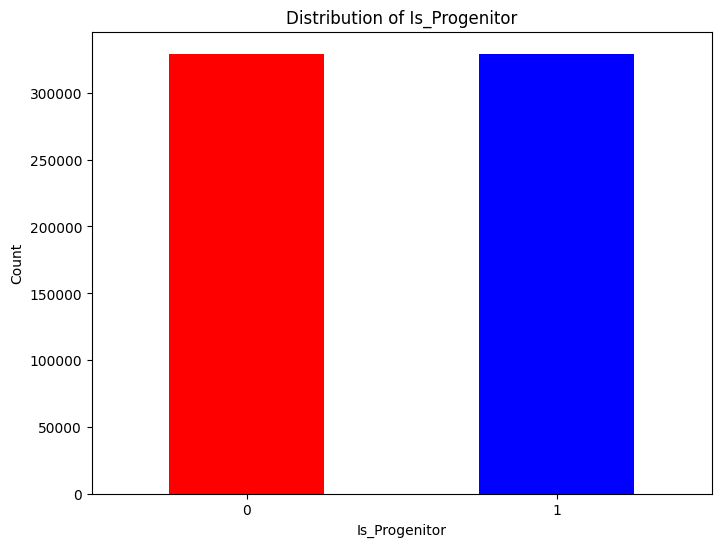

In [ ]:
import matplotlib.pyplot as plt

# Plotting the distribution of the 'Is_Progenitor' column
plt.figure(figsize=(8, 6))
training_data['Is_Progenitor'].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.title('Distribution of Is_Progenitor')
plt.xlabel('Is_Progenitor')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
